# Load Senitnel-2 data from the CDSE STAC catalog

This notebook shows an example how to load Sentinel-2 data from the [CDSE STAC API](https://documentation.dataspace.copernicus.eu/APIs/STAC.html).

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac). You may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) directly from the git repository by cloning the repository, directing into `xcube-stac`, and following the steps below:

```bash
conda env create -f environment.yml
conda activate xcube-stac
pip install .
```

Note that [`xcube_stac`](https://github.com/xcube-dev/xcube-stac) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store, get_data_store_params_schema
from xcube_stac._utils import reproject_bbox
import itertools

CPU times: user 5.16 s, sys: 545 ms, total: 5.71 s
Wall time: 3.99 s


Next store the credentials in a dictionary. 

In [2]:
credentials = {
    "key": "xxx",
    "secret": "xxx"
}

First, we get the store parameters needed to initialize a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). Note that key and secret of the S3 access are required.

In [3]:
%%time
store_params = get_data_store_params_schema("stac-cdse")
store_params

CPU times: user 69.5 ms, sys: 19 ms, total: 88.5 ms
Wall time: 84.3 ms


Note that the user does not need to provide the URL for the [CDSE STAC API](https://documentation.dataspace.copernicus.eu/APIs/STAC.html). Only the key and secret for S3 access are required when initializing a `stac-cdse` [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). First, we will initialize a store supporting the stacking mode. Then, for completeness, we will initialize a store in single-tile mode.

In [4]:
%%time
store = new_data_store("stac-cdse", stack_mode=True, **credentials)

CPU times: user 39.4 ms, sys: 8.03 ms, total: 47.4 ms
Wall time: 136 ms


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

In [5]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 15.6 ms, sys: 2.95 ms, total: 18.5 ms
Wall time: 69.7 ms


['COP-DEM',
 'S2GLC',
 'TERRAAQUA',
 'SENTINEL-3',
 'SENTINEL-5P',
 'SENTINEL-1-RTC',
 'SENTINEL-1',
 'SMOS',
 'LANDSAT-7',
 'CCM',
 'LANDSAT-5',
 'ENVISAT',
 'LANDSAT-8-ESA',
 'SENTINEL-6',
 'GLOBAL-MOSAICS',
 'SENTINEL-2']

Below, the parameters for the `open_data` method can be viewed. Note that `processing_level` and and [`processing_baseline`](https://sentiwiki.copernicus.eu/web/s2-processing#S2Processing-ProcessingBaseline) can be selected. 

In [6]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 280 μs, sys: 0 ns, total: 280 μs
Wall time: 283 μs


So far, only data from the collection `SENTINEL-2` can be accessed. We therefore assign `data_id` to `"SENTINEL-2"`. We set the bounding box to cover the greater Hamburg area and the time range to July 2020. Additionally, we assign the processing level to `"L2A"`.

In [7]:
%%time
bbox = [9.1, 53.1, 10.7, 54]
crs_target = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_target)
time_range = ["2020-07-15", "2020-08-01"]

CPU times: user 2.53 ms, sys: 67 μs, total: 2.6 ms
Wall time: 1.86 ms


In [8]:
%%time
ds = store.open_data(
    data_id="SENTINEL-2",
    bbox=bbox_utm,
    time_range=time_range,
    processing_level="L2A",
    spatial_res=20,
    crs=crs_target,
    asset_names=["B02", "B03", "B04"],
    apply_scaling=True,
)
ds

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.12/site-packages/pystac_client/item_search.py:447: DoesNotConformTo: Server does not conform to SORT
  warnings.warn(DoesNotConformTo("SORT"))
Stack tiles along time axis.: 100%|█| 11/11 [00:56<00:00,  5.14s/i

CPU times: user 11.8 s, sys: 1.84 s, total: 13.7 s
Wall time: 1min 49s


<xarray.Dataset> Size: 4GB
Dimensions:  (time: 11, y: 5073, x: 5237)
Coordinates:
  * y        (y) float64 41kB 5.985e+06 5.985e+06 ... 5.883e+06 5.883e+06
  * x        (x) float64 42kB 5.067e+05 5.067e+05 ... 6.114e+05 6.114e+05
  * time     (time) datetime64[ns] 88B 2020-07-15T12:15:59.024000 ... 2020-07...
Data variables:
    B02      (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03      (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04      (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    crs      int64 8B 0
Attributes:
    stac_catalog_url:  https://catalogue.dataspace.copernicus.eu/stac
    stac_item_ids:     {'2020-07-15T12:15:59.024000': ['S2B_MSIL2A_20200715T1...

Note that the search function in the CDSE STAC API is very slow. Further investigation and comparison with other STAC APIs is needed. 

We can plot a tile of the B04 (red) band for a given timestamp as an example. Note that the bounding box encompasses all tiles within the dataset, so without mosaicking, many of the pixels will be NaN values.

CPU times: user 28.4 s, sys: 4.91 s, total: 33.3 s
Wall time: 43.4 s


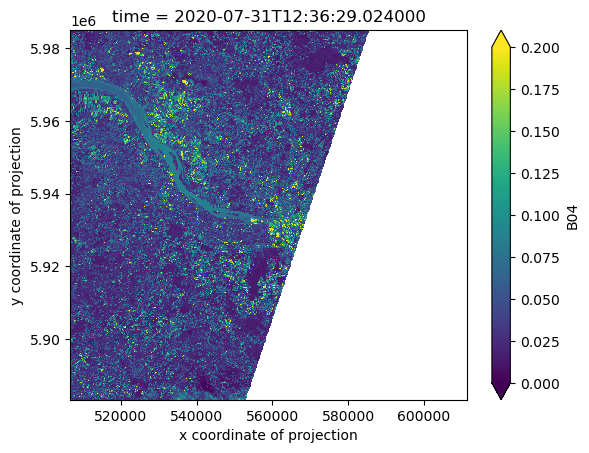

In [9]:
%%time
ds.B04.isel(time=-1)[::10, ::10].plot(vmin=0.0, vmax=0.2)

----
## Data store in the single-tile
For completeness, we initiate the data store in the single-tile mode and open data of one tile. 

In [10]:
%%time
store = new_data_store("stac-cdse", stack_mode=False, **credentials)

CPU times: user 16.2 ms, sys: 1.7 ms, total: 18 ms
Wall time: 160 ms


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be streamed using the following code where we show the first 10 data IDs as an example.

In [11]:
%%time
data_ids = store.get_data_ids()
list(itertools.islice(data_ids, 10))

CPU times: user 15 ms, sys: 4.46 ms, total: 19.5 ms
Wall time: 409 ms


['collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T193419_V20160225T072708_20160225T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T194404_V20160226T235943_20160227T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T193142_V20160223T235943_20160224T225600',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T194851_V20160227T235943_20160228T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T212947_V20160317T235943_20160318T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T220217_V20160324T235943_20160325T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T195832_V20160229T235943_20160301T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T214844_V20160321T235943_20160322T235942',
 'collections/SENTINEL-3/items/S3A_OPER_AUX_GNSSRD_POD__20171212T205619_V20160311T235943_20160312T235942',
 'collections/SENTINEL-3/items/S3A_OP

In the next step, we can search for items using search parameters. The following code shows which search parameters are available.

In [12]:
%%time
search_params = store.get_search_params_schema()
search_params

CPU times: user 31 μs, sys: 0 ns, total: 31 μs
Wall time: 34.6 μs


 Note that since only the data access for Sentinel-2 data is supported so far, we will search for tiles of Sentinel-2 data.

In [13]:
%%time
descriptors = list(
    store.search_data(
        collections=["SENTINEL-2"],
        bbox=[9, 47, 10, 48],
        time_range=["2020-07-01", "2020-07-05"],
        processing_level="L2A", 
    )
)
[d.to_dict() for d in descriptors]

/home/konstantin/micromamba/envs/xcube-stac/lib/python3.12/site-packages/pystac_client/item_search.py:447: DoesNotConformTo: Server does not conform to SORT
  warnings.warn(DoesNotConformTo("SORT"))


CPU times: user 310 ms, sys: 37.5 ms, total: 348 ms
Wall time: 9 s


[{'data_id': 'collections/SENTINEL-2/items/S2A_MSIL2A_20200703T103031_N0500_R108_T32UNU_20230613T212700.SAFE',
  'data_type': 'dataset',
  'bbox': [8.99972790410621,
   47.7610550948757,
   10.0947734594677,
   48.7530130044756],
  'time_range': ('2020-07-03T10:30:31.024000Z',
   '2020-07-03T10:30:31.024000Z')},
 {'data_id': 'collections/SENTINEL-2/items/S2A_MSIL2A_20200703T103031_N0500_R108_T32UMU_20230613T212700.SAFE',
  'data_type': 'dataset',
  'bbox': [7.63917680224736,
   47.7574035317346,
   9.13278260997073,
   48.7529365097654],
  'time_range': ('2020-07-03T10:30:31.024000Z',
   '2020-07-03T10:30:31.024000Z')},
 {'data_id': 'collections/SENTINEL-2/items/S2A_MSIL2A_20200703T103031_N0214_R108_T32TNT_20200703T142409.SAFE',
  'data_type': 'dataset',
  'bbox': [8.99973201751709,
   46.86417007446289,
   9.683835983276367,
   47.853702545166016],
  'time_range': ('2020-07-03T10:30:31.024000Z',
   '2020-07-03T10:30:31.024000Z')},
 {'data_id': 'collections/SENTINEL-2/items/S2A_MSIL2A_

In the next step, we can open the data for each data ID. The following code shows which parameters are available for opening the data.

In [14]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 232 μs, sys: 0 ns, total: 232 μs
Wall time: 237 μs


We select the band B04 (red), B03 (green), and B02 (blue) and lazily load the corresponding data.

In [15]:
%%time
ds = store.open_data(
    descriptors[3].data_id,
    asset_names=["B04", "B03", "B02"],
    apply_scaling=True,
    spatial_res=60
)
ds

CPU times: user 153 ms, sys: 31.9 ms, total: 185 ms
Wall time: 2.05 s


<xarray.Dataset> Size: 40MB
Dimensions:  (x: 1830, y: 1830)
Coordinates:
  * x        (x) float64 15kB 5e+05 5.001e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y        (y) float64 15kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    B04      (y, x) float32 13MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B03      (y, x) float32 13MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    B02      (y, x) float32 13MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    crs      int64 8B 0
Attributes:
    stac_catalog_url:  https://catalogue.dataspace.copernicus.eu/stac
    stac_item_id:      S2A_MSIL2A_20200703T103031_N0214_R108_T32UNU_20200703T...

We plot the loaded data as an example below.

CPU times: user 2.54 s, sys: 256 ms, total: 2.8 s
Wall time: 7.13 s


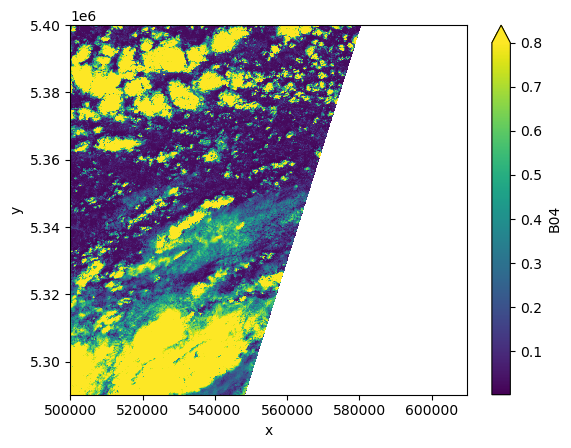

In [16]:
%%time
ds.B04.plot(vmax=0.8)

We can also open a `.jp2` as a [xcube's multi-resolution  dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html#xcube-multi-resolution-datasets), where we can select the level of resolution, shown below.  